# Why sum correlations?
As all the terms in the cross-correlations checked independently seem to work, we now want to check if we can reproduce the problem by combining the different terms obtained separatedly.

In [1]:
# We will work with the multibias 1 box. Therefore the effective biases are:
biases = {
    1 : 0,
    4 : 1.13,
    5 : 1.5,
}

## Reconstructing full expression for s4(rsd)_s5(rsd)

We use this combination as it requires all the terms in our RSD model. Our generalized model starts by assuming this expression for the density field in redshift space:

$$\delta^{s, {\rm A}} = \delta_{\rm LN}^{\rm b_A} + r_{\rm A} \cdot f \mu^2 \delta_{\rm L}$$ 

$$\delta^{s, {\rm B}} = \delta_{\rm LN}^{\rm b_B} + r_{\rm B} \cdot f \mu^2 \delta_{\rm L}$$ 

where $r_{\rm x} \equiv 0$ if no-RSD and $r_{\rm x} \equiv 1$ if RSD. 

Therefore:

$$P(k) = <\delta_{\rm LN}^{\rm b_A} \delta_{\rm LN}^{\rm b_B}> + 
r_{\rm B} f \mu^2 <\delta_{\rm LN}^{\rm b_A}\delta_{\rm L}> + 
r_{\rm A} f \mu^2 <\delta_{\rm LN}^{\rm b_B}\delta_{\rm L}> +  
r_{\rm A} r_{\rm B} f^2 \mu^4 <\delta_L \delta_L>$$



And for the s4(rsd)_s5(rsd) case:

$$P(k) = <\delta_{\rm LN}^{\rm b_A} \delta_{\rm LN}^{\rm b_B}>  +  
 f^2 \mu^4 <\delta_L \delta_L>+ 
 f \mu^2 <\delta_{\rm LN}^{\rm b_A}\delta_{\rm L}> + 
 f \mu^2 <\delta_{\rm LN}^{\rm b_B}\delta_{\rm L}>$$

The terms in the cross-correlation can be recovered each one by:

$<\delta_{\rm LN}^{\rm b_A} \delta_{\rm LN}^{\rm b_B}>$: (0) Computing the cross-correlation of the fields without RSD.

$f^2 \mu^4 <\delta_L \delta_L>$: (1) Auto-correlation unclustered source s1.

$f \mu^2 <\delta_{\rm LN }^{\rm b_A} \delta_L>$: (2) Cross-correlation s1-s4(norsd).

$f \mu^2 <\delta_{\rm LN }^{\rm b_B} \delta_L>$: (3) Cross-correlation s1-s5(norsd).



We can also get some mixed terms by looking at these other cross-correlations:

(02): s4(norsd)_s5(rsd)

(03): s4(rsd)_s5(norsd)

(12): s1(rsd)_s4(rsd)

(13): s1(rsd)_s5(rsd)

(0123): s4(rsd)_s5(rsd)

All the other mixed terms cannot be obtained independently: (23) (01) (0 1 2) (0 1 3) (0 2 3) (1 2 3)

In this notebook we will compute a certain mix of terms and see that they can be reproduced by summing each term (or a combination of terms) independently. 
(E.g: The full cross-correlation (0123) should be the sum of the correlations (0)+(12)+(3)

## ¡¡Scroll all the way down to see results!!:

In [2]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

theory_path=Path('/global/cscratch1/sd/damonge/CoLoRe_sims/sim1000')
bias_filename=Path('/global/cscratch1/sd/cramirez/NBodyKit/hanyu_david_box/input_files/BzBlue.txt')
nz_filename=Path('/global/cscratch1/sd/cramirez/NBodyKit/hanyu_david_box/input_files/NzBlue.txt')
pk_filename=Path('/global/cscratch1/sd/cramirez/NBodyKit/hanyu_david_box/input_files/Pk_CAMB_test.dat')

theory = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=2,
    nz_filename=nz_filename,
    pk_filename=pk_filename,
    param_cfg_filename='/global/cscratch1/sd/damonge/CoLoRe_sims/sim1000/out_params.cfg',
    bias_filename=bias_filename,
    apply_lognormal=True)

zmin=0.5
zmax=0.7
z = theory.get_zeff(zmin=zmin, zmax=zmax) #the usual redshift range


class Results:
    def __init__(self, label):
        self.label = label
    
    def __str__(self):
        return self.label
    
    def get_cf_from_boxes(self, sub_boxes):
        xis = np.array([np.asarray(box.halotools_like_cf).sum(axis=1) for box in sub_boxes])
        return xis.mean(axis=0)#, xis.std(ddof=1, axis=0)/np.sqrt(len(sub_boxes))   
    
def get_npole_legendre(order, npole):
    from scipy.special import legendre
    from scipy.integrate import quad

    L = legendre(order)
    return (2*npole+1)/2 * quad(L, -1, 1)[0]
        
    
model = Results('model')
data = Results('data')


In [3]:
def get_boxes(source1, source2, rsd1, rsd2, force_path=None):
    if force_path != None:
        boxes_path = force_path
    elif source2==None:
        boxes_path=Path(f'/global/cscratch1/sd/cramirez/NBodyKit/multibias/s{source1}/analysis')
    else:
        boxes_path=Path(f'/global/cscratch1/sd/cramirez/NBodyKit/cross_correlations/multibias/s{source1}_s{source2}')
        
    sub_boxes = FileFuncs.mix_sims(
        FileFuncs.get_full_path(boxes_path,
                                rsd=rsd1, rsd2=rsd2, #Must specify here rsd2 
                                rmin=0.1, rmax=200, N_bins=41,
                                zmin=zmin, zmax=zmax, #Also results for 0.7 and 0.9
                                nside=2)
    )
    
    return sub_boxes

In [4]:
poles = [0, 2]

In [5]:
data.boxes = dict()
model.biases = dict()

data.xi = dict()
data.xierr = dict()
model.xi = dict()

In [6]:
label='0'
source1=4
rsd1=False
bias1=biases[source1]

source2=5
rsd2=False
bias2=biases[source2]

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [7]:
label='1'
source1=1
rsd1=True
bias1=biases[source1]

source2=None
rsd2=None
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [8]:
label='2'
source1=1
rsd1=True
bias1=biases[source1]


source2=4
rsd2=False
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [9]:
label='3'
source1=1
rsd1=True
bias1=biases[source1]

source2=5
rsd2=False
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [10]:
label='02'
source1=4
rsd1=False
bias1=biases[source1]

source2=5
rsd2=True
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [11]:
label='03'
source1=4
rsd1=True
bias1=biases[source1]

source2=5
rsd2=False
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [12]:
label='12'
source1=1
rsd1=True
bias1=biases[source1]

source2=4
rsd2=True
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [13]:
label='13'
source1=1
rsd1=True
bias1=biases[source1]

source2=5
rsd2=True
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

In [14]:
label='0123'
source1=4
rsd1=True
bias1=biases[source1]

source2=5
rsd2=True
bias2=biases[source2] if source2!=None else None

data.boxes[label] = get_boxes(source1=source1, source2=source2, rsd1=rsd1, rsd2=rsd2)
if len(data.boxes[label]) == 0:
    raise ValueError('no boxes found')
model.biases[label] = (bias1, bias2)

data.xi[label] = dict()
data.xierr[label] = dict()
model.xi[label] = dict()
for pole in poles:
    data.xi[label][pole], data.xierr[label][pole] = Plots.get_xi(pole=pole, boxes=data.boxes[label])
    model.xi[label][pole] = theory.get_npole(n=pole, z=z, rsd=rsd1, bias=bias1, rsd2=rsd2, bias2=bias2, smooth_factor=1, smooth_factor_rsd=1, smooth_factor_cross=1)

# Plots

In [15]:
data.r = data.boxes['0'][0].savg

In [16]:
def get_sum_from_labels(labels, poles=[0,2]):
    _dataxi = dict()
    _dataxierr = dict()
    _theoryxi = dict()
    for pole in poles:
        _dataxi[pole] = np.zeros_like(data.r)
        _dataxierr[pole] = np.zeros_like(data.r)
        _theoryxi[pole] =np.zeros_like(theory.r)
        for label in labels:
            _dataxi[pole] += data.xi[label][pole]
            _dataxierr[pole] += data.xierr[label][pole]
            _theoryxi[pole] += model.xi[label][pole]
    return _dataxi, _dataxierr, _theoryxi

In [17]:
def plot_sum(ax, labels, poles=[0,2], c='C0', **kwargs):
    _dataxi, _dataxierr, _theoryxi = get_sum_from_labels(labels)
    for pole in poles:
        if pole == poles[0]:
            label = "+".join(labels)
        else:
            label = None
        ax.plot(theory.r, theory.r**2*_theoryxi[pole], c=c, label=label, **kwargs)
        ax.errorbar(data.r, data.r**2*_dataxi[pole], data.r**2*_dataxierr[pole], c=c, fmt='.', **kwargs)

In [18]:
%matplotlib inline

We can start by reproducing the term 03. For the monopole this involves the mix of two terms, but only one for the quadrupole.

For this case we do not see any bad behaviour in the quadrupole.

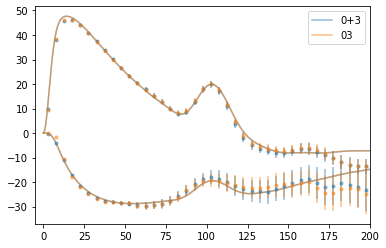

In [19]:
fig, ax = plt.subplots()

plot_sum(ax, ['0','3'], c='C0', alpha=0.5)
plot_sum(ax, ['03'], c='C1', alpha=0.5)
ax.set_xlim(-5, 200)
ax.legend();

The combination (12) is more more intersting as it requries mixing two terms both for the monopole and the quadrupole.

It might be possible that we start to see the prediction and the model depart at low scales:

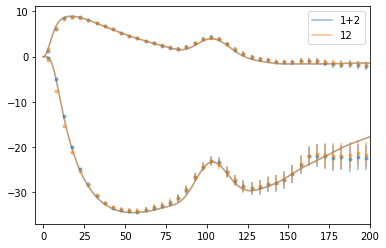

In [20]:
fig, ax = plt.subplots()

plot_sum(ax, ['1','2'], c='C0', alpha=0.5)
plot_sum(ax, ['12'], c='C1', alpha=0.5)
ax.set_xlim(-5, 200)
ax.legend();

Exactly the same effect happens when mixing (12). In this case, the bias acting is the one from s5, so the effect should be larger.
I think this effect can be observed.

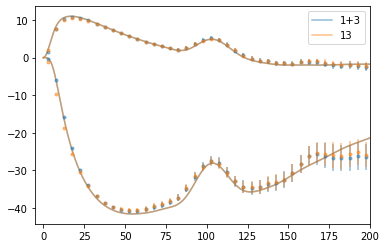

In [21]:
fig, ax = plt.subplots()

plot_sum(ax, ['1','3'], c='C0', alpha=0.5)
plot_sum(ax, ['13'], c='C1', alpha=0.5)
ax.set_xlim(-5, 200)
ax.legend();

Then plots for the full model. When combining all the terms (0123), the effect is strong here. 
We are not able to reproduce it by mixing other terms.

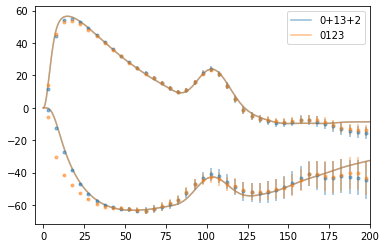

In [22]:
fig, ax = plt.subplots()

plot_sum(ax, ['0','13','2'], c='C0', alpha=0.5)
plot_sum(ax, ['0123'], c='C1', alpha=0.5)
ax.set_xlim(-5, 200)
ax.legend();

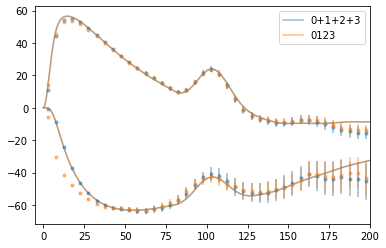

In [23]:
fig, ax = plt.subplots()

plot_sum(ax, ['0','1','2','3'], c='C0', alpha=0.5)
plot_sum(ax, ['0123'], c='C1', alpha=0.5)
ax.set_xlim(-5, 200)
ax.legend();

It seems like our model is not completely able to describe the data.
We are using all the time the approximation:

$$ \delta_{\rm gal} = \delta_{\rm LN} + \delta_{\rm RSD}$$

where we basically cut all higher order terms in the expression:

$$ ( 1 + \delta_{\rm LN}^s) = \frac{1 + \delta_{LN}}{1 + \frac{\partial_Z v_z}{H}} \simeq 1 + \delta_{\rm LN} - \frac{\partial_z v_z}{H}$$